### AJUSTE DO AMBIENTE E IMPORTAÇÃO DE BIBLIOTECAS A SEREM USADAS

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV
# from skopt import BayesSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

### WEB SCRAPPING DOS DADOS DIRETO DO SITE 'CRUZEIROPEDIA'

In [3]:
# faz a requisição HTTP para a página principal
response = requests.get('https://cruzeiropedia.org/Categoria:Temporadas')

# faz o parsing do HTML da página principal
soup = BeautifulSoup(response.content, 'html.parser')

In [ ]:
# encontra todas as tags <a> que contêm o nome das temporadas (identifica os links) 
temporadas = soup.find_all('a', {'title': 
                                 ['Categoria:Temporada 2011',
                                  'Categoria:Temporada 2012',
                                  'Categoria:Temporada 2013',
                                  'Categoria:Temporada 2014',
                                  'Categoria:Temporada 2015',
                                  'Categoria:Temporada 2016',
                                  'Categoria:Temporada 2017', 
                                  'Categoria:Temporada 2018', 
                                  'Categoria:Temporada 2019', 
                                  'Categoria:Temporada 2020', 
                                  'Categoria:Temporada 2021', 
                                  'Categoria:Temporada 2022',
                                  'Categoria:Temporada 2023',
                                  'Categoria:Temporada 2024']
                                  }
                                  )

In [6]:
# lista para armazenar os dados encontrados
anos = []
diasSemanas = []
datas = []
adversarios = []
pubPagantes = []
pubPresentes = []
rendaBrutas = []
estadios = []
campeonatos = []
placares = []
horarios = []

# 'varre' a lista de temporadas especificada acima
for temporada in temporadas:
    # obtém o link da temporada
    link_temporada = temporada.get('href')
    
    # faz a requisição HTTP para a página da temporada
    response_temporada = requests.get('https://cruzeiropedia.org' + link_temporada)
    
    # faz o parsing do HTML da página da temporada
    soup_temporada = BeautifulSoup(response_temporada.content, 'html.parser')
    
    # identifica os jogos que o cruzeiro foi mandante na temporada em questão
    jogos = soup_temporada.find_all('a', {'title': re.compile(r'(.+) (\d+)x(\d+) (.+) - (\d{2}/\d{2}/\d{4})')})

    # entra em cada um dos jogos
    for jogo in jogos:
        # obtém o link do jogo
        link_jogos = jogo.get('href')

        if "Slovan" in link_jogos:
            continue

        elif "Tr%C3%ADplice" in link_jogos:
            continue
    
        # faz a requisição HTTP para a página do jogo
        response_jogos = requests.get('https://cruzeiropedia.org' + link_jogos)
        # faz o parsing do html da página do jogo
        soup_jogos = BeautifulSoup(response_jogos.content, 'html.parser')
        # retira a informação do dia da semana e horário
        diaSemana = soup_jogos.find('b', string='Data:').next_sibling.strip()
        diasSemanas.append(diaSemana)

        ano = soup_jogos.find('b', string='Data:').find_next_sibling().find_next_sibling().text.strip()
        anos.append(ano)

        data = soup_jogos.find('b', string='Data:').find_next_sibling().text.strip()
        datas.append(data)

        adversario = soup_jogos.find('b', string='Placar').find_next_sibling().find_next_sibling().find_next_sibling().text.strip()
        adversarios.append(adversario)

        pubPagante = soup_jogos.find('b', string='Público pagante:').next_sibling.strip()
        pubPagantes.append(pubPagante)

        pubPresente = soup_jogos.find('b', string='Público Presente:').next_sibling.strip()
        pubPresentes.append(pubPresente)

        rendaBruta = soup_jogos.find('b', string='Renda Bruta:').next_sibling.strip()
        rendaBrutas.append(rendaBruta)

        estadio = soup_jogos.find('b', string='Estádio:').find_next_sibling().text.strip()
        estadios.append(estadio)
        
        campeonato = soup_jogos.find('div', class_='divFichaSessao')
        campeonato_element = campeonato.find('b')
        campeonato_element_title = campeonato_element.text.strip()
        campeonatos.append(campeonato_element_title)

        placar_element = soup_jogos.find('div', class_='divFicha')
        placar = placar_element.find('b').text
        placares.append(placar)

        horario = soup_jogos.find('b', string='Data:').find_next_sibling().find_next_sibling().next_sibling.strip()
        horarios.append(horario)



### ESTRUTURAÇÃO DOS DADOS COLETADOS EM DATAFRAME + PRÉ-VISUALIZAÇÃO DOS DADOS

In [7]:
# ESTRUTURANDO OS DADOS CAPTURADOS EM UM DATAFRAME

df_raw = pd.DataFrame({'visitante':adversarios,
                       'ano': anos,
                       'dia da semana': diasSemanas,
                       'data': datas,
                       'publico presente': pubPresentes,
                       'publico pagante':pubPagantes,
                       'renda bruta': rendaBrutas,
                       'estadio':estadios,
                       'campeonato':campeonatos,
                       'placar':placares,
                       'horario':horarios})
df = df_raw.copy()

In [11]:
# Salvando em um excel para evitar de ter que rodar o web scrapping inteiro toda vez que for trabalhar 

df_raw.to_excel("C:\\Users\\Dudu_\\OneDrive\\Documentos\\Estudos\\1. Projetos Pessoais\\0. Datasets Usados\\Dataset Cruzeiro\\Cruzeiro.xlsx", index=False)

In [125]:
df_raw = pd.read_excel("C:\\Users\\Dudu_\\OneDrive\\Documentos\\Estudos\\1. Projetos Pessoais\\0. Datasets Usados\\Dataset Cruzeiro\\Cruzeiro.xlsx")

df = df_raw.copy()

In [126]:
# Análise da cauda final do df para ver se o script deu certo e se são os jogos mais recentes mesmo
df.tail(5)

,visitante,ano,dia da semana,data,publico presente,publico pagante,renda bruta,estadio,campeonato,placar,horario
875,Cruzeiro,2024,"quinta-feira,",19 de setembro,Não disponível,Não disponível,Não informado,Defensores del Chaco,Jogo de ida - Quartas de Final da Copa Sul-Ame...,0 × 2,às 21:30
876,Cruzeiro,2024,"domingo,",22 de setembro,5.948,4.236,"R$ 129.730,00",Arena Pantanal,27ª rodada do Campeonato Brasileiro 2024,0 × 0,às 18:30
877,Libertad,2024,"quinta-feira,",27 de setembro,52.974,52.974,"R$ 2.829.293,00",Mineirão,Jogo de volta - Quartas de Final da Copa Sul-A...,1 × 1,às 21:30
878,Vasco,2024,"domingo,",29 de setembro,36.817,33.431 (6.674 sócios),"R$ 1.283.610,00",Mineirão,28ª roada do Campeonato Brasileiro 2024,1 × 1,às 18:30
879,Cruzeiro,2024,"quinta-feira,",3 de outubro,Não disponível,Não disponível,Não informado,Maracanã,29ª rodada do Campeonato Brasileiro 2024,1 × 0,às 21:30


### FILTRANDO APENAS CAMPEONATO BRASILEIRO - AMOSTRA A SER TRABALHADA

In [127]:
# Dicionário de mapeamento para os nomes dos campeonatos
mapa_campeonatos = {
    'Mineiro': 'Campeonato Mineiro',
    'Libertadores': 'Libertadores',
    'Amistoso': 'Amistoso',
    'Copa do Brasil': 'Copa do Brasil',
    'Brasileiro': 'Brasileirão',
    'Primeira Liga': 'Primeira Liga',
    'Sul-Americana': 'Sul-Americana',
    'Inconfidência': 'Inconfidência',
    'Sul-Minas-Rio': 'Copa Sul-Minas-Rio'
}

# Função para ajustar os nomes
def ajustar_nome(campeonato):
    for chave, valor in mapa_campeonatos.items():
        if chave in campeonato:
            return valor
    return 'nao'

# Aplicando a função ao dataframe
df['camp_ajustado'] = df['campeonato'].apply(ajustar_nome)


In [128]:
# FILTRANDO APENAS BRASILEIRAO
df = df[df['camp_ajustado'] == "Brasileirão"].reset_index(drop='index')

### DATA WRANGLING

In [129]:
# RETIRADA DA VÍRGULA NO FINAL DO DIA DA SEMANA
df['dia da semana'] = df['dia da semana'].str[:-1]

# SEPARAÇÃO DA COLUNA DATA EM DIA E MÊS
df[['dia do mes', 'mes']] = df['data'].str.split(' de ', expand= True)

# ALTERANDO OS NOMES DOS MESES PARA NÚMEROS
meses_para_numeros ={
                     'janeiro': 1,
                     'fevereiro': 2,
                     'março': 3,
                     'abril': 4,
                     'maio': 5,
                     'junho': 6,
                     'julho': 7,
                     'agosto': 8,
                     'setembro': 9,
                     'outubro': 10,
                     'novembro': 11,
                     'dezembro': 12
                    }

df['mes'] = df['mes'].map(meses_para_numeros)

# RETIRADA DO R$ NO RENDA BRUTA
df['renda bruta'] = df['renda bruta'].str.slice(start=2)

# RETIRADA DOS PARÊNTESES COM AS INFOS DOS SÓCIOS DO PUB PAGANTE 
df[['publico pagante','erro1','erro2']] = df['publico pagante'].str.split(' ',expand=True)
df.drop(columns=['erro1','erro2'],inplace=True)

# AJUSTE DA COLUNA DE HORÁRIO - RETIRADA DA STRING ÀS E DOS :/;
df['horario'] = df['horario'].str.slice(start=3)
df['horario'] = df['horario'].str.replace(';',':')
df['horario'] = df['horario'].str.replace(':','')

# CONSERTANDO OS SEPARADORES NÚMERICOS (, E .) DAS COLUNAS NUMÉRICAS
for i in range(0,len(df)):
    df['renda bruta'][i] = df['renda bruta'][i].replace('.','')
    df['renda bruta'][i] = df['renda bruta'][i].replace(',','.')
    df['publico presente'][i] = df['publico presente'][i].replace('.','')
    df['publico pagante'][i] = df['publico pagante'][i].replace('.','')

# AJUSTANDO A COLUNA DE PLACAR
df[['golsMandante','golsVisitante']] = df['placar'].str.split(' × ',expand=True).astype(int)

# CRIANDO UMA NOVA PARA COM PONTOS ALCANÇADOS NA PARTIDA
df['pontosAlcancados'] = None
for i in range(0,len(df)):
    if df['golsMandante'][i] == df['golsVisitante'][i]:
        df['pontosAlcancados'][i] = 1

    elif df['golsMandante'][i] > df['golsVisitante'][i] and df['visitante'][i] == 'Cruzeiro':
        df['pontosAlcancados'][i] = 0

    elif df['golsMandante'][i] > df['golsVisitante'][i] and df['visitante'][i] != 'Cruzeiro':
        df['pontosAlcancados'][i] = 3

    elif df['golsMandante'][i] < df['golsVisitante'][i] and df['visitante'][i] == 'Cruzeiro':
        df['pontosAlcancados'][i] = 3

    elif df['golsMandante'][i] < df['golsVisitante'][i] and df['visitante'][i] != 'Cruzeiro':
        df['pontosAlcancados'][i] = 0

# CRIANDO UMA NOVA COLUNA COM O RESULTADO DO JOGO
df['resultado'] = None
for i in range(0,len(df)):
    if df['pontosAlcancados'][i] == 0:
        df['resultado'][i] = "Derrota"
    elif df['pontosAlcancados'][i] == 1:
        df['resultado'][i] = "Empate"
    elif df['pontosAlcancados'][i] == 3:
        df['resultado'][i] = "Vitoria"
    else:
        df['resultado'][i] = "Erro"

# CRIANDO NOVA COLUNA DE APROVEITAMENTO

df['aproveitamento_geral_previo'] = None

indice_primeiro_jogo_do_ano = 0
ano_em_questao = None

for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['aproveitamento_geral_previo'][i] = 0
        ano_em_questao = df['ano'][i]  

    elif df['ano'][i] != df['ano'][i-1]:
        df['aproveitamento_geral_previo'][i] = 0
        indice_primeiro_jogo_do_ano = i
        ano_em_questao = df['ano'][i]

    else:
        df['aproveitamento_geral_previo'][i] = df[(df.index < i)&(df['ano'] == ano_em_questao)]['pontosAlcancados'].sum()/((i-indice_primeiro_jogo_do_ano)*3)

# CRIANDO COLUNA DE JOGOS DE INVENCIBILIDADE

df['sequencia_invencibilidade_previa'] = None
seq_teste = 0
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['sequencia_invencibilidade_previa'][i] = 0
    elif df['ano'][i] != df['ano'][i-1]:
        df['sequencia_invencibilidade_previa'][i] = 0
    elif df['resultado'][i-1] == 'Vitoria':
        seq_teste += 1
        df['sequencia_invencibilidade_previa'][i] = seq_teste
    elif df['resultado'][i-1] == 'Empate':
        seq_teste += 1
        df['sequencia_invencibilidade_previa'][i] = seq_teste
    else:
        seq_teste = 0
        df['sequencia_invencibilidade_previa'][i] = 0

# CRINDO UMA VARIÁVEL DUMMY INDICANDO SE TRATA DO PRIMEIRO JOGO DA TEMPORADA
df['estreia'] = None
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['estreia'][i] = 1
    elif df['ano'][i] != df['ano'][i-1]:
        df['estreia'][i] = 1
    else:
        df['estreia'][i] = 0

# CRINDO UMA VARIÁVEL DUMMY INDICANDO SE É CLASSICO
df['classico'] = None
for i,v in enumerate(range(0,len(df))):
    if df['visitante'][i] == "Atlético-MG":
        df['classico'][i] = 1
    else:
        df['classico'][i] = 0

# CRIANDO COLUNA DO RESULTADO DO ULTIMO JOGO
df['resultado_ultJogo'] = df['resultado'].shift(1)

df.loc[df['estreia'] == 1, 'resultado_ultJogo'] = "Estreia"

# CRIANDO COLUNA DE SALDO DE GOLS NO ULTIMO JOGO

df['saldoGols_ultJogo'] = df['golsMandante'].shift(1) - df['golsVisitante'].shift(1)

df.loc[df['estreia'] == 1, 'saldoGols_ultJogo'] = 0

### DATA CLEANING

In [130]:
# CONFERINDO LINHAS DUPLICADAS
df.duplicated().sum()

np.int64(0)

In [131]:
# CONFERINDO LINHAS NULAS
df.isnull().sum()

visitante                           0
ano                                 0
dia da semana                       0
data                                0
publico presente                    0
publico pagante                     0
renda bruta                         0
estadio                             0
campeonato                          0
placar                              0
horario                             0
camp_ajustado                       0
dia do mes                          0
mes                                 0
golsMandante                        0
golsVisitante                       0
pontosAlcancados                    0
resultado                           0
aproveitamento_geral_previo         0
sequencia_invencibilidade_previa    0
estreia                             0
classico                            0
resultado_ultJogo                   0
saldoGols_ultJogo                   0
dtype: int64

In [132]:
# CONFERINDO FORMATOS DE ESCRITA DISTINTOS NA COLUNA DE HORARIO
df['horario'].unique()

array(['1600', '1830', '2100', '1930', '2200', '1800', '2030', '2150',
       '1700', '1900', '1620', '15h', '1100', '2145', '2000', '1630',
       '1915', '2130', '2015', '1815', '190', '19h', '16h'], dtype=object)

In [133]:
# FORMATANDO CADA UM DOS REGISTROS INCOERENTES
df['horario'] = df['horario'].str.replace('h','00')
df['horario'] = df['horario'].str.replace('190','1900')

In [134]:
# NOVOS VALORES DE HORARIOS
df['horario'].unique()

array(['1600', '1830', '2100', '1930', '2200', '1800', '2030', '2150',
       '1700', '19000', '1620', '1500', '1100', '2145', '2000', '1630',
       '1915', '2130', '2015', '1815', '1900'], dtype=object)

In [135]:
# COLOCANDO O NOME ANTIGO E O NOVO NOME DA ARENA JACARÉ DA MESMA FORMA. TRATAM-SE DO MESMO ESTÁDIO

df['estadio'] = df['estadio'].replace('Arena Buser','Arena do Jacaré')

EXPLICAÇÃO DO REMOÇÃO DE ALGUMAS COLUNAS 

>>PUBLICO PRESENTE -> dados muito poluídos, com alguns registros de "não disponível".  
>>CAMPEONATO e CAMP_AJUSTADO -> como trata-se apenas de brasileirão não faz sentido mantê-las  
>>PLACAR -> a coluna placar foi segregada entre as colunas de golsCruzeiro e golsAdversario  
>>DATA -> coluna foi desmembrada e não faz mais sentido mantê-la  
>>ANO -> usada apenas como regra para novas variáveis. Sem usabilidade e sem sentido  
>>golsMandante, golsVisitante, pontosAlcancados e resultados -> informações usadas apenas para criar regras de novas colunas criadas. São informações que não são conhecidas no momento da predição e por isso não servem como variáveis x  
>>RENDA BRUTA -> vazaria dados. 

In [136]:
# RETIRANDO COLUNAS NÃO UTILIZADAS

colunas_excluidas = ['publico presente','placar','data','campeonato','camp_ajustado']

df = df.drop(columns=colunas_excluidas)

### DATA PREPARATION

In [137]:
# MANTENDO APENAS OS REGISTROS DO CRUZEIRO COMO MANDANTE
df = df[df['visitante'] != "Cruzeiro"].reset_index(drop='index')

In [138]:
# CRIANDO VARIÁVEL COM INFO DO APROVEITAMENTO EM CASA

indice_primeiro_jogo_em_casa = 0

df['aproveitamentoEmCasa_previo'] = None
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['aproveitamentoEmCasa_previo'][i] = 0
        ano_em_questao = df['ano'][i]  

    elif df['ano'][i] != df['ano'][i-1]:
        df['aproveitamentoEmCasa_previo'][i] = 0
        indice_primeiro_jogo_em_casa = i
        ano_em_questao = df['ano'][i]

    else:
        df['aproveitamentoEmCasa_previo'][i] = df[(df.index < i)&(df['ano'] == ano_em_questao)]['pontosAlcancados'].sum()/((i-indice_primeiro_jogo_em_casa)*3)

In [139]:
# CRIANDO COLUNA DE ESTREIA EM CASA

df['estreia_em_casa'] = None
for i,v in enumerate(range(0,len(df))):
    if i == 0:
        df['estreia_em_casa'][i] = 1
    elif df['ano'][i] != df['ano'][i-1]:
        df['estreia_em_casa'][i] = 1
    else:
        df['estreia_em_casa'][i] = 0

In [140]:
# CRIANDO COLUNA DE SALDO DE GOLS NO ULTIMO JOGO EM CASA

df['saldoGols_ultJogoEmCasa'] = df['golsMandante'].shift(1) - df['golsVisitante'].shift(1)

df.loc[df['estreia_em_casa'] == 1, 'saldoGols_ultJogoEmCasa'] = 0

In [142]:
# CONFERINDO TIPO DE DADOS PARA MANUTENÇÃO
df.dtypes

visitante                            object
ano                                   int64
dia da semana                        object
publico pagante                      object
renda bruta                          object
estadio                              object
horario                              object
dia do mes                           object
mes                                   int64
golsMandante                          int64
golsVisitante                         int64
pontosAlcancados                     object
resultado                            object
aproveitamento_geral_previo          object
sequencia_invencibilidade_previa     object
estreia                              object
classico                             object
resultado_ultJogo                    object
saldoGols_ultJogo                   float64
aproveitamentoEmCasa_previo          object
estreia_em_casa                      object
saldoGols_ultJogoEmCasa             float64
dtype: object

In [143]:
# ALTERANDO O TIPO DE DADOS DE CADA COLUNA UMA A UMA PARA FACILITAR A IDENTIFICAÇÃO

df['visitante'] = df['visitante'].astype('category')                         
df['dia da semana'] = df['dia da semana'].astype('category')                                                  
df['publico pagante']= df['publico pagante'].astype('float')                               
df['estadio'] = df['estadio'].astype('category')                                                             
df['dia do mes'] = df['dia do mes'].astype(int)                   
df['mes'] = df['mes'].astype(int)
df['ano'] = df['ano'].astype(int)                                                           
df['aproveitamento_geral_previo'] = df['aproveitamento_geral_previo'].astype('float')               
df['sequencia_invencibilidade_previa'] = df['sequencia_invencibilidade_previa'].astype(int)    
df['estreia'] = df['estreia'].astype(int)
df['classico'] = df['classico'].astype(int)
df['horario'] = df['horario'].astype(int)
df['golsMandante'] = df['golsMandante'].astype(int)
df['golsVisitante'] = df['golsVisitante'].astype(int)
df['resultado_ultJogo'] = df['resultado_ultJogo'].astype('category')
df['renda bruta'] = df['renda bruta'].astype('float')
df['aproveitamentoEmCasa_previo'] = df['aproveitamentoEmCasa_previo'].astype('float')
df['estreia_em_casa'] = df['estreia_em_casa'].astype(int)
df['resultado'] = df['resultado'].astype('category')
df['pontosAlcancados'] = df['pontosAlcancados'].astype(int)


In [144]:
# NOVOS TIPOS DE DADOS
df.dtypes

visitante                           category
ano                                    int64
dia da semana                       category
publico pagante                      float64
renda bruta                          float64
estadio                             category
horario                                int64
dia do mes                             int64
mes                                    int64
golsMandante                           int64
golsVisitante                          int64
pontosAlcancados                       int64
resultado                           category
aproveitamento_geral_previo          float64
sequencia_invencibilidade_previa       int64
estreia                                int64
classico                               int64
resultado_ultJogo                   category
saldoGols_ultJogo                    float64
aproveitamentoEmCasa_previo          float64
estreia_em_casa                        int64
saldoGols_ultJogoEmCasa              float64
dtype: obj

In [ ]:
#df['publico pagante_ultJogoEmCasa'] = df['publico pagante'].shift(1)
#df['renda bruta_ultJogoEmCasa'] = df['renda bruta'].shift(1)

In [145]:
df.drop(['resultado','renda bruta', 'golsMandante', 'golsVisitante','pontosAlcancados'], axis=1, inplace=True)

In [146]:
df = df[(df['ano'] != 2020) & (df['ano'] != 2021)]

In [29]:
# drop do jogo do vasco - será usado para predição futura por conta da restrição de público que houve no jogo
df.drop(244,inplace=True)

In [175]:
df[df['estadio'] == 'Mineirão']

,visitante,ano,dia da semana,publico pagante,estadio,horario,dia do mes,mes,aproveitamento_geral_previo,sequencia_invencibilidade_previa,estreia,classico,resultado_ultJogo,saldoGols_ultJogo,aproveitamentoEmCasa_previo,estreia_em_casa,saldoGols_ultJogoEmCasa
41,Náutico,2013,domingo,15528.0,Mineirão,1830,14,7,0.500000,3,0,0,Empate,0.0,0.777778,0,0.0
42,Atlético-MG,2013,domingo,35689.0,Mineirão,1600,28,7,0.625000,5,0,1,Vitoria,-3.0,0.833333,0,3.0
43,Coritiba,2013,sábado,25108.0,Mineirão,1830,3,8,0.600000,0,0,0,Derrota,1.0,0.866667,0,3.0
44,Santos,2013,domingo,27533.0,Mineirão,1600,11,8,0.666667,2,0,0,Vitoria,-1.0,0.888889,0,1.0
45,Vitória,2013,sábado,14369.0,Mineirão,1830,17,8,0.595238,0,0,0,Derrota,2.0,0.809524,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Atlético-MG,2024,sábado,57525.0,Mineirão,2130,10,8,0.583333,0,0,1,Derrota,-1.0,0.888889,0,-1.0
258,Internacional,2024,quarta-feira,31935.0,Mineirão,1930,28,8,0.536232,0,0,0,Derrota,1.0,0.833333,0,0.0
259,Atlético-GO,2024,domingo,54592.0,Mineirão,1100,1,9,0.527778,1,0,0,Empate,0.0,0.787879,0,0.0
260,São Paulo,2024,domingo,41011.0,Mineirão,1830,15,9,0.546667,2,0,0,Vitoria,2.0,0.805556,0,2.0


### MODELLING

#### TREINAMENTO INICIAL

In [182]:
# RETIRADA DE ALGUMAS FEATURES QUE ESTAVAM PIORANDO A PERFORMANCE DO MODELO
df_predict = df.drop(['visitante','estadio'],axis=1)
df_final = pd.get_dummies(df_predict)

In [183]:
df_final

,ano,publico pagante,horario,dia do mes,mes,aproveitamento_geral_previo,sequencia_invencibilidade_previa,estreia,classico,saldoGols_ultJogo,...,dia da semana_quarta-feira,dia da semana_quinta-feira,dia da semana_segunda-feira,dia da semana_sexta-feira,dia da semana_sábado,dia da semana_terça-feira,resultado_ultJogo_Derrota,resultado_ultJogo_Empate,resultado_ultJogo_Estreia,resultado_ultJogo_Vitoria
0,2011,9080.0,1600,29,5,0.000000,0,0,0,1.0,...,False,False,False,False,False,False,True,False,False,False
1,2011,6073.0,1830,11,6,0.111111,0,0,0,1.0,...,False,False,False,False,True,False,True,False,False,False
2,2011,5252.0,2100,25,6,0.200000,2,0,0,0.0,...,False,False,False,False,True,False,False,True,False,False
3,2011,10652.0,1930,6,7,0.428571,4,0,0,-3.0,...,True,False,False,False,False,False,False,False,False,True
4,2011,6666.0,1830,17,7,0.444444,0,0,0,1.0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2024,57525.0,2130,10,8,0.583333,0,0,1,-1.0,...,False,False,False,False,True,False,True,False,False,False
258,2024,31935.0,1930,28,8,0.536232,0,0,0,1.0,...,True,False,False,False,False,False,True,False,False,False
259,2024,54592.0,1100,1,9,0.527778,1,0,0,0.0,...,False,False,False,False,False,False,False,True,False,False
260,2024,41011.0,1830,15,9,0.546667,2,0,0,2.0,...,False,False,False,False,False,False,False,False,False,True


In [184]:
# SEPARAÇÃO DA VARIÁVEL TARGET E VARIÁVEIS PREDITORAS
y = df_final['publico pagante']
X = df_final.drop('publico pagante',axis=1)

In [196]:
# SPLIT DOS DADOS EM BASE DE TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# TREINAMENTO DO MODELO XGBOOST
xgb = XGBRegressor(n_estimators = 1000, 
                   max_depth=6, 
                   random_state=200,
                   early_stopping_rounds=50,
                   learning_rate = 0.01)

xgb.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

# PREDIÇÃO DO MODELO XGBOOST
yxgb = xgb.predict(X_test)

# MÉTRICAS DO MODELO XGBOOST
mae_xgb = mean_absolute_error(y_test,yxgb)
mse_xgb = mean_squared_error(y_test,yxgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test,yxgb)
adj_r2_xgb = 1-(1-r2_xgb)*(len(df)-1)/(len(df)-len(df.columns)-1)

[0]	validation_0-rmse:13676.78419	validation_1-rmse:12980.25603
[20]	validation_0-rmse:11853.99751	validation_1-rmse:11903.14486
[40]	validation_0-rmse:10356.37473	validation_1-rmse:11197.50991
[60]	validation_0-rmse:9130.15982	validation_1-rmse:10692.65173
[80]	validation_0-rmse:8101.50297	validation_1-rmse:10294.69869
[100]	validation_0-rmse:7221.74938	validation_1-rmse:10078.52361
[120]	validation_0-rmse:6462.92556	validation_1-rmse:9932.34879
[140]	validation_0-rmse:5820.61049	validation_1-rmse:9872.03158
[160]	validation_0-rmse:5275.26075	validation_1-rmse:9852.29703
[180]	validation_0-rmse:4794.58050	validation_1-rmse:9832.34805
[200]	validation_0-rmse:4372.10767	validation_1-rmse:9855.62206
[220]	validation_0-rmse:4008.82382	validation_1-rmse:9934.13248
[234]	validation_0-rmse:3766.11250	validation_1-rmse:9996.80959


In [197]:
importances = xgb.feature_importances_

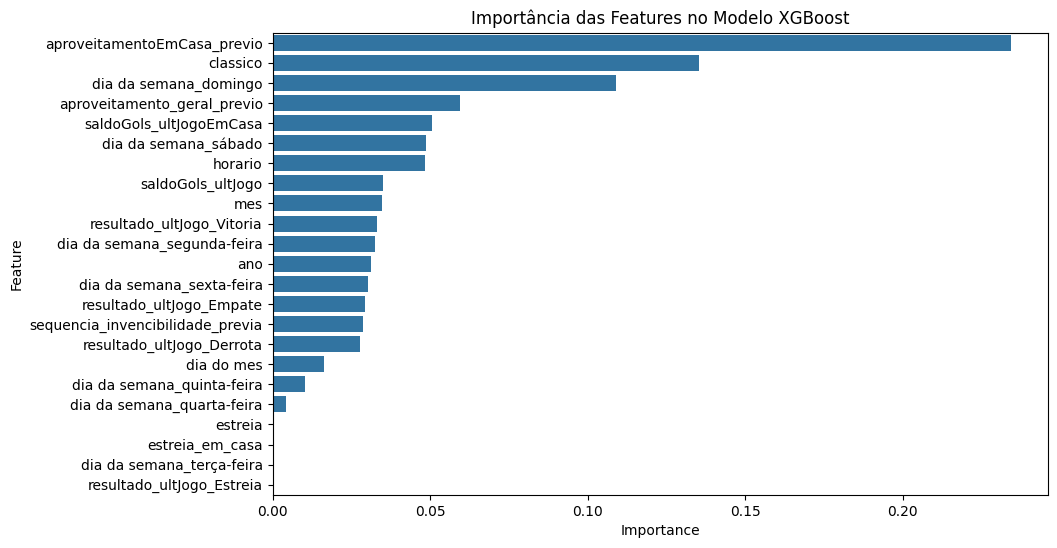

In [198]:
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Passo 3: Ordenar as features pela importância
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Passo 4: Plotar o gráfico de importâncias
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Importância das Features no Modelo XGBoost')
plt.show()

In [199]:
feature_importances_df

,Feature,Importance
9,aproveitamentoEmCasa_previo,0.234261
7,classico,0.135442
12,dia da semana_domingo,0.109103
4,aproveitamento_geral_previo,0.059620
11,saldoGols_ultJogoEmCasa,0.050591
17,dia da semana_sábado,0.048759
1,horario,0.048478
8,saldoGols_ultJogo,0.035183
3,mes,0.034665
22,resultado_ultJogo_Vitoria,0.033087


In [200]:
# TREINAMENTO DO MODELO RANDOM FOREST
rf = RandomForestRegressor(n_estimators= 600, max_depth=25, random_state=200).fit(X_train,y_train)

# PREDIÇÃO DO MODELO RANDOM FOREST
yrf = rf.predict(X_test)

# MÉTRICAS DO MODELO RANDOM FOREST
mae_rf = mean_absolute_error(y_test,yrf)
mse_rf = mean_squared_error(y_test,yrf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test,yrf)
adj_r2_rf = 1-(1-r2_rf)*(len(df)-1)/(len(df)-len(df.columns)-1)

In [201]:
# PRINT DAS MÉTRICAS ALCANÇADAS POR CADA MODELO
print('--------MÉTRICAS XGBOOST--------')
print(f'mae: {mae_xgb}\nmse: {mse_xgb}\nrmse: {rmse_xgb}\nr2: {r2_xgb}\nr2 ajustado: {adj_r2_xgb}')
print('')
print('-----MÉTRICAS RANDOM FOREST-----')
print(f'mae: {mae_rf}\nmse: {mse_rf}\nrmse: {rmse_rf}\nr2: {r2_rf}\nr2 ajustado: {adj_r2_rf}')

--------MÉTRICAS XGBOOST--------
mae: 7422.686451631434
mse: 96590312.90838002
rmse: 9828.037083180956
r2: 0.42791850393627207
r2 ajustado: 0.3807078950378091

-----MÉTRICAS RANDOM FOREST-----
mae: 8262.427107843137
mse: 120567662.21289806
rmse: 10980.330696882405
r2: 0.28590635542214093
r2 ajustado: 0.22697629737445357


In [38]:
# TIRANDO A MÉDIA DAS PREDIÇÕES DE CADA UM DOS MODELOS PARA VER SE O RESULTADO MELHORA (TEOREMA DAS MULTIDÕES)
ymisto = (yrf + yxgb)/2

mae_misto = mean_absolute_error(y_test,ymisto)
mse_misto = mean_squared_error(y_test,ymisto)
rmse_misto = np.sqrt(mse_misto)
r2_misto = r2_score(y_test,ymisto)
adj_r2_misto = 1-(1-r2_misto)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('-----MÉTRICAS MISTO-----')
print(f'mae: {mae_misto}\nmse: {mse_misto}\nrmse: {rmse_misto}\nr2: {r2_misto}\nr2 ajustado: {adj_r2_misto}')


-----MÉTRICAS MISTO-----
mae: 5813.469880674751
mse: 56589111.654079914
rmse: 7522.573472826963
r2: 0.6438098641417409
r2 ajustado: 0.6197197100257235


#### OTIMIZAÇÃO DOS MODELOS

> GRIDSEARCHCV - XGBOOST

In [ ]:
# Definição dos parâmetros a serem testados

parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Inicializando o modelo

xgb_model = XGBRegressor()

# Encontrando os melhores hiperparâmetros 

grid_search = GridSearchCV(estimator=xgb_model, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Extraindo a melhor combinação de parâmetros encontrada

best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)
print('')

# Treinando o modelo com os melhores hiperparâmetros

grid_xgb = XGBRegressor(**best_params)
grid_xgb.fit(X_train, y_train)

# Previsão do modelo otimizado

y_grid_xgb = grid_xgb.predict(X_test)

# Avaliando os resultados

mae_grid_xgb = mean_absolute_error(y_test,y_grid_xgb)
mse_grid_xgb = mean_squared_error(y_test,y_grid_xgb)
rmse_grid_xgb = np.sqrt(mse_grid_xgb)
r2_grid_xgb = r2_score(y_test,y_grid_xgb)
adj_r2_grid_xgb = 1-(1-r2_grid_xgb)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('--------MÉTRICAS XGBOOST OTIMIZADO--------')
print(f'mae: {mae_grid_xgb}\nmse: {mse_grid_xgb}\nrmse: {rmse_grid_xgb}\nr2: {r2_grid_xgb}\nr2 ajustado: {adj_r2_grid_xgb}')

>BAYESSEARCHCV - XGBOOST

In [43]:
# Inicializando o modelo e definindo os parâmetros a serem testados
opt_xgb = BayesSearchCV(
                    XGBRegressor(),
                    {
                    'learning_rate': [0.01, 0.1, 0.2],
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 4, 5],
                    'min_child_weight': [1, 2, 3],
                    'subsample': [0.8, 0.9, 1.0],
                    'colsample_bytree': [0.8, 0.9, 1.0],
                    },
                    scoring='neg_mean_squared_error',
                    cv=5
                   )

opt_xgb.fit(X_train, y_train)

# Extraindo a melhor combinação de parâmetros encontrada
best_params_bayes_xgb = opt_xgb.best_params_

# Criação dos modelos com os melhores parâmetros encontrados
bayes_xgb = XGBRegressor(**best_params_bayes_xgb)

# Treinamento do modelo otimizado
bayes_xgb.fit(X_train, y_train)

# Previsões do modelo otimizado
y_bayes_xgb = bayes_xgb.predict(X_test)

# Avaliando os resultados

mae_bayes_xgb = mean_absolute_error(y_test,y_bayes_xgb)
mse_bayes_xgb = mean_squared_error(y_test,y_bayes_xgb)
rmse_bayes_xgb = np.sqrt(mse_bayes_xgb)
r2_bayes_xgb = r2_score(y_test,y_bayes_xgb)
adj_r2_bayes_xgb = 1-(1-r2_bayes_xgb)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('--------MÉTRICAS XGBOOST OTIMIZADO--------')
print(f'mae: {mae_bayes_xgb}\nmse: {mse_bayes_xgb}\nrmse: {rmse_bayes_xgb}\nr2: {r2_bayes_xgb}\nr2 ajustado: {adj_r2_bayes_xgb}')

--------MÉTRICAS XGBOOST OTIMIZADO--------
mae: 6976.92524576823
mse: 82888896.72103375
rmse: 9104.333952631228
r2: 0.6134709129586139
r2 ajustado: 0.5937332574501175


> GRIDSEARCHCV - RANDOM FOREST

In [42]:
# Definição dos parâmetros a serem testados

parameters = {
    'n_estimators': [500,550,600,650,700],
    'max_depth': [20,25,30,35],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'bootstrap': [True, False]
}

# Inicializando o modelo

rf_model = RandomForestRegressor()

# Encontrando os melhores hiperparâmetros 

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
grid_search_rf.fit(X_train, y_train)

# Extraindo a melhor combinação de parâmetros encontrada

best_params_rf = grid_search_rf.best_params_
print("Melhores hiperparâmetros:", best_params_rf)
print('')

# Treinando o modelo com os melhores hiperparâmetros

grid_rf = RandomForestRegressor(**best_params_rf)
grid_rf.fit(X_train, y_train)

# Previsão do modelo otimizado

y_grid_rf = grid_rf.predict(X_test)

# Avaliando os resultados

mae_grid_rf = mean_absolute_error(y_test,y_grid_rf)
mse_grid_rf = mean_squared_error(y_test,y_grid_rf)
rmse_grid_rf = np.sqrt(mse_grid_rf)
r2_grid_rf = r2_score(y_test,y_grid_rf)
adj_r2_grid_rf = 1-(1-r2_grid_rf)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('--------MÉTRICAS RANDOM FOREST OTIMIZADO--------')
print(f'mae: {mae_grid_rf}\nmse: {mse_grid_rf}\nrmse: {rmse_grid_rf}\nr2: {r2_grid_rf}\nr2 ajustado: {adj_r2_grid_rf}')

KeyboardInterrupt: 

In [41]:
grid_search_rf

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [20, 25, 30, 35],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [500, 550, 600, 650, 700],
                         'random_state': [200]},
             scoring='neg_mean_squared_error')

> BAYESSEARCHCV - RANDOM FOREST

In [ ]:
# Inicializando o modelo e definindo os parâmetros a serem testados
opt_rf = BayesSearchCV(
                    RandomForestRegressor(),
                    {
                     'n_estimators': [500,550,600,650,700],
                     'max_depth': [20,25,30,35],
                     'min_samples_split': [2, 5, 10],
                     'min_samples_leaf': [1, 2, 4],
                     'max_features': ['sqrt', 'log2'],
                     'bootstrap': [True, False],
                     'random_state':[200]
                    },
                    scoring='neg_mean_squared_error',
                    cv=5
                   )

opt_rf.fit(X_train, y_train)

# Extraindo a melhor combinação de parâmetros encontrada
best_params_bayes_rf = opt_rf.best_params_

# Criação dos modelos com os melhores parâmetros encontrados
bayes_rf = XGBRegressor(**best_params_bayes_rf)

# Treinamento do modelo otimizado
bayes_rf.fit(X_train, y_train)

# Faça previsões no conjunto de teste
y_bayes_rf = bayes_rf.predict(X_test)

# Avaliando os resultados

mae_bayes_rf = mean_absolute_error(y_test,y_bayes_rf)
mse_bayes_rf = mean_squared_error(y_test,y_bayes_rf)
rmse_bayes_rf = np.sqrt(mse_bayes_rf)
r2_bayes_rf = r2_score(y_test,y_bayes_rf)
adj_r2_bayes_rf = 1-(1-r2_bayes_rf)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('--------MÉTRICAS RANDOM FOREST OTIMIZADO--------')
print(f'mae: {mae_bayes_rf}\nmse: {mse_bayes_rf}\nrmse: {rmse_bayes_rf}\nr2: {r2_bayes_rf}\nr2 ajustado: {adj_r2_bayes_rf}')

--------MÉTRICAS RANDOM FOREST OTIMIZADO--------
mae: 5075.5397716446505
mse: 44370049.305884816
rmse: 6661.08469439361
r2: 0.7657346449139918
r2 ajustado: 0.7536174713750603


In [ ]:
# TIRANDO A MÉDIA DAS PREDIÇÕES DE CADA UM DOS MODELOS PARA VER SE O RESULTADO MELHORA
ymisto2 = (yrf + y_grid_xgb)/2

mae_misto2 = mean_absolute_error(y_test,ymisto2)
mse_misto2 = mean_squared_error(y_test,ymisto2)
rmse_misto2 = np.sqrt(mse_misto2)
r2_misto2 = r2_score(y_test,ymisto2)
adj_r2_misto2 = 1-(1-r2_misto2)*(len(df)-1)/(len(df)-len(df.columns)-1)

print('-----MÉTRICAS MISTO-----')
print(f'mae: {mae_misto2}\nmse: {mse_misto2}\nrmse: {rmse_misto2}\nr2: {r2_misto2}\nr2 ajustado: {adj_r2_misto2}')



-----MÉTRICAS MISTO-----
mae: 4726.665250154786
mse: 36144667.12717195
rmse: 6012.04350675974
r2: 0.8091630861025556
r2 ajustado: 0.7992922112457912


>> Mesmo com a otimização feita utilizando o GridSearch e o a busca Bayesiana, os resultados encontrados antes da tentativa de otimização foram melhores. Dessa forma, foi decidido manter o modelo da forma inicial.

### TESTE FINAL

#### PREDIÇÃO JOGO DO VASCO - DIA 22/11

O jogo do Cruzeiro x Vasco, do dia 22/11, não contou com a presença de torcedores no estádio por conta de uma punição sofrida pelo Cruzeiro (punição decorrente da invasão de torcedores cruzeirenses no jogo da 34ª rodada do Campeonato Brasileiro contra o Coritiba, na Vila Capanema).
Por conta disso, foi decidido fazer a previsão com o modelo criado da possível quantidade de público nesse jogo caso a punição não existisse.

In [ ]:
# PREDIÇÃO DE PÚBLICO DO JOGO CRUZEIRO X VASCO

# DEFININDO OS ATRIBUTOS
vasco = np.array([2023,1900,11,0.491120,1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False])

# REDIMENSIONANDO A ARRAY PARA FICAR NO FORMATO IDEAL DE ENTRADA NO MODELO
vasco = vasco.reshape(1,-1)

# PREDIÇÃO DOS DOIS MODELOS 
yvasco_xgb = xgb.predict(vasco)
yvasco_rf = rf.predict(vasco)

# MÉDIA DA AVALIAÇÃO DOS DOIS MODELOS PARA ENCONTRAR O RESULTADO FINAL
publico_possivel = (yvasco_xgb + yvasco_rf)/2

print(f"A previsão de público para o jogo entre Cruzeiro e Vasco foi de {publico_possivel[0]:.0f} torcedores.")

A previsão de público para o jogo entre Cruzeiro e Vasco foi de 34337 torcedores.
